In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from sgnNet import SGN
from dataset import Seq2PointWindows
from training import main_train_masked 
from refit_dataloader import load_house_csv
from inference import infer_seq2point_timeline_all, infer_seq2point_timeline_all_with_hard, tune_hysteresis_for_mae, smape


In [2]:
DATAPATH = r"C:\\Users\\rcper\SGN_NILM\\refit_data\\CLEAN_House2.csv"
APPLIANCE_COL = "Appliance2"
MAX_ROWS = 750000
RESAMPLE_RULE = "30s"
WIN_LEN = 256
STRIDE = 32
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
BACKBONE_KIND = "tcn"
PATIENCE = 10
MIN_DELTA = 0.0
ALPHA_REG_RAW = 0.25
ALPHA_ON = 2.0
ALPHA_OFF = 0.1
BETA_CLS = 1
FOCAL_GAMMA = 2.0
ON_SAMPLE_PROB = 0.10

CKPT_PATH = "sgn_best.pt"

In [3]:
mains, target, ts = load_house_csv(
    DATAPATH, appliance_col=APPLIANCE_COL, max_rows=MAX_ROWS, resample_rule=RESAMPLE_RULE
)
print(f"Loaded {len(mains)} samples for House2 / {APPLIANCE_COL}")

n = len(mains)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

mains_train, target_train = mains[:train_end], target[:train_end]
mains_val,   target_val   = mains[train_end:val_end], target[train_end:val_end]
mains_test,  target_test  = mains[val_end:], target[val_end:]

# Datasets (use your Seq2PointWindows to get scaling)
train_ds = Seq2PointWindows(mains_train, target_train, win_len=WIN_LEN, stride=STRIDE, train=True)
val_ds   = Seq2PointWindows(mains_val,   target_val,   win_len=WIN_LEN, stride=STRIDE, train=False)
test_ds  = Seq2PointWindows(mains_test,  target_test,  win_len=WIN_LEN, stride=STRIDE, train=False)

# Loss hyperparams based on dataset scale/imbalance
delta = 50.0 / (train_ds.target_scale + 1e-6)  
pos_rate = float(train_ds.onoff.mean() + 1e-9)
neg_rate = 1.0 - pos_rate
pos_weight = min(neg_rate / pos_rate, 8.0)

Loaded 750000 samples for House2 / Appliance2


In [ ]:
results = main_train_masked(
    mains_train, target_train,
    mains_val,   target_val,
    win_len=WIN_LEN, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, kind=BACKBONE_KIND,
    patience=PATIENCE, min_delta=MIN_DELTA, ckpt_path=CKPT_PATH,
    use_scheduler=True, plot=True,
    alpha_on=ALPHA_ON, alpha_off=ALPHA_OFF, beta_cls=BETA_CLS,
    alpha_reg_raw=ALPHA_REG_RAW,
    delta_huber=delta,
    focal_gamma=FOCAL_GAMMA,
    pos_weight=pos_weight,
    on_sample_prob=ON_SAMPLE_PROB
)


Epoch 001 | Train 9.5328 | Val 0.9362 | Val MAE (W): 108.55 | logs: ON 4.086 OFF 0.405 CLS 0.292 | MAE@ON: 171.79 | MAE@OFF: 105.03
Epoch 002 | Train 6.6928 | Val 0.7748 | Val MAE (W): 98.74 | logs: ON 2.870 OFF 0.467 CLS 0.209 | MAE@ON: 161.87 | MAE@OFF: 95.22
Epoch 003 | Train 6.5098 | Val 0.9724 | Val MAE (W): 121.81 | logs: ON 2.794 OFF 0.460 CLS 0.187 | MAE@ON: 167.16 | MAE@OFF: 119.28
Epoch 004 | Train 6.5952 | Val 0.8646 | Val MAE (W): 108.71 | logs: ON 2.835 OFF 0.484 CLS 0.182 | MAE@ON: 163.06 | MAE@OFF: 105.68
Epoch 005 | Train 6.1684 | Val 0.5626 | Val MAE (W): 61.27 | logs: ON 2.656 OFF 0.437 CLS 0.159 | MAE@ON: 158.32 | MAE@OFF: 55.86
Epoch 006 | Train 7.4726 | Val 0.6522 | Val MAE (W): 91.21 | logs: ON 3.222 OFF 0.494 CLS 0.175 | MAE@ON: 143.67 | MAE@OFF: 88.29
Epoch 007 | Train 6.5607 | Val 0.7300 | Val MAE (W): 92.79 | logs: ON 2.811 OFF 0.475 CLS 0.207 | MAE@ON: 149.57 | MAE@OFF: 89.62
Epoch 008 | Train 6.1293 | Val 0.8599 | Val MAE (W): 119.40 | logs: ON 2.620 OFF 0.5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CKPT_PATH, map_location=device)
model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

# Get gate temperature (use from stats if you saved it; else default)
gate_tau = stats.get("gate_tau", 0.75) if isinstance(stats, dict) else 0.75

# --- Validation outputs (for tuning hysteresis) ---
pow_val_soft, reg_val_w, prob_val = infer_seq2point_timeline_all(model, mains_val, stats, device, gate_tau=gate_tau)
y_val = target_val

C:\Users\rcper\AppData\Local\Temp\ipykernel_15212\44307241.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


In [ ]:
# Tune (t_on, t_off, min_hold) for MAE over validation
t_on, t_off, min_hold, best_val_mae = tune_hysteresis_for_mae(reg_val_w, prob_val, y_val, gate_floor=0.0)
print(f"[TUNE] Best on VAL → t_on={t_on:.2f}, t_off={t_off:.2f}, min_hold={min_hold} | MAE={best_val_mae:.2f} W")

[TUNE] Best on VAL → t_on=0.85, t_off=0.50, min_hold=5 | MAE=5.41 W


In [ ]:
power_soft_w, reg_w, prob, gate_hard, power_hard_w = infer_seq2point_timeline_all_with_hard(
    model, mains_test, stats, device,
    gate_tau=gate_tau,
    t_on=t_on, t_off=t_off, min_hold=min_hold,
    gate_floor=0.0
)
y_true = target_test

In [ ]:
# -----------------------------
# Metrics
# -----------------------------

mae_soft = float(np.mean(np.abs(power_soft_w - y_true)))
mae_hard = float(np.mean(np.abs(power_hard_w - y_true)))

energy_true = float(y_true.sum())
sae_soft = float(abs(power_soft_w.sum() - energy_true) / (energy_true + 1e-6))
sae_hard = float(abs(power_hard_w.sum() - energy_true) / (energy_true + 1e-6))

print(f"[TEST][SOFT] MAE (W): {mae_soft:.2f} | SAE: {sae_soft:.4f} | sMAPE: {smape(y_true, power_soft_w):.2f}%")
print(f"[TEST][HARD] MAE (W): {mae_hard:.2f} | SAE: {sae_hard:.4f} | sMAPE: {smape(y_true, power_hard_w):.2f}%")


[TEST][SOFT] MAE (W): 10.05 | SAE: 0.1327 | sMAPE: 95.89%
[TEST][HARD] MAE (W): 8.34 | SAE: 0.0225 | sMAPE: 3.79%


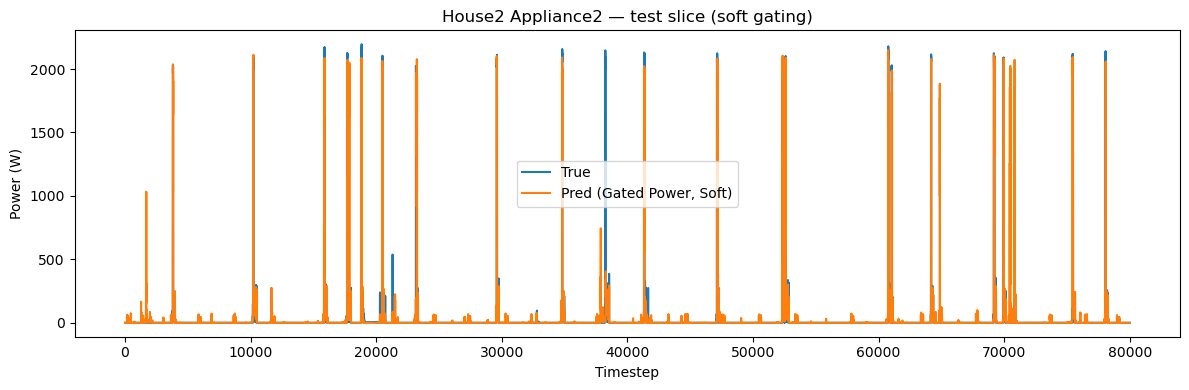

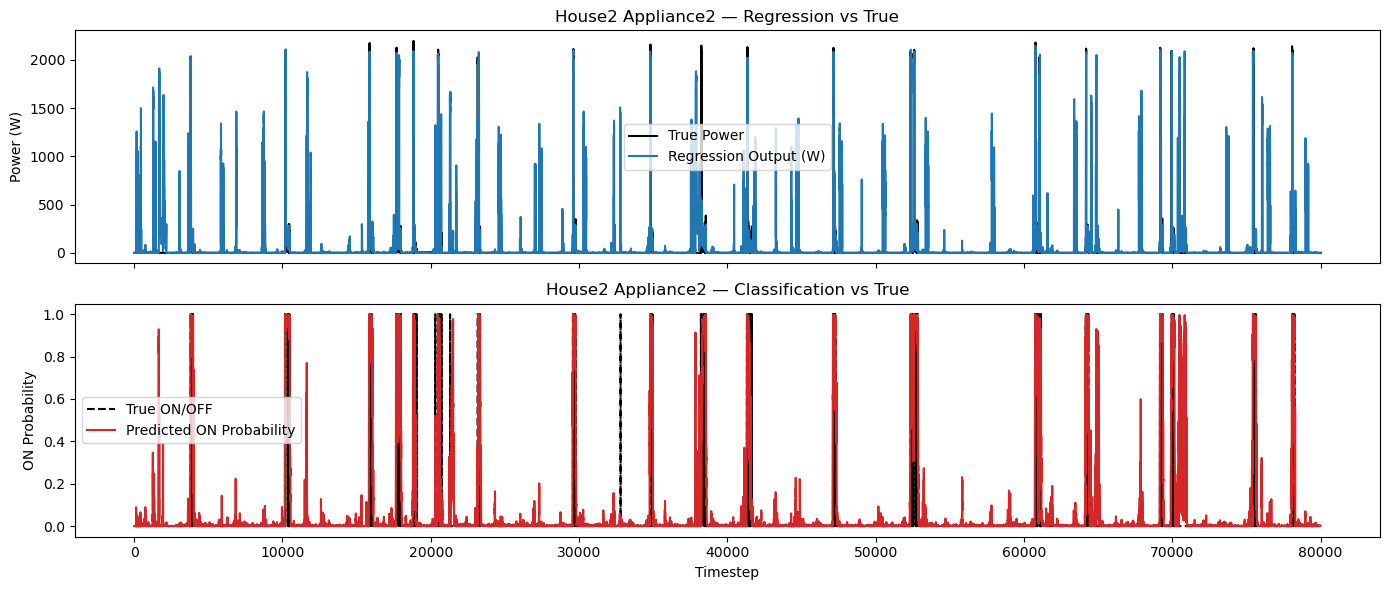

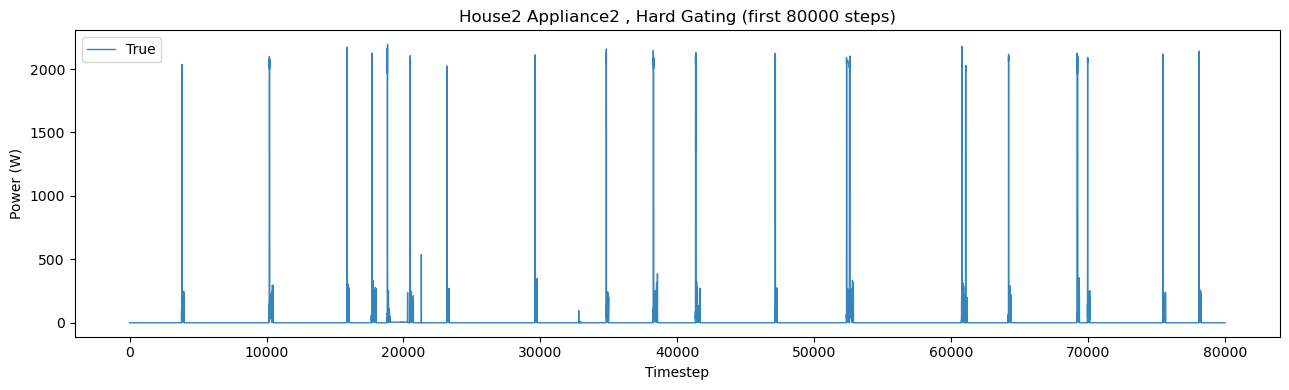

<Figure size 640x480 with 0 Axes>

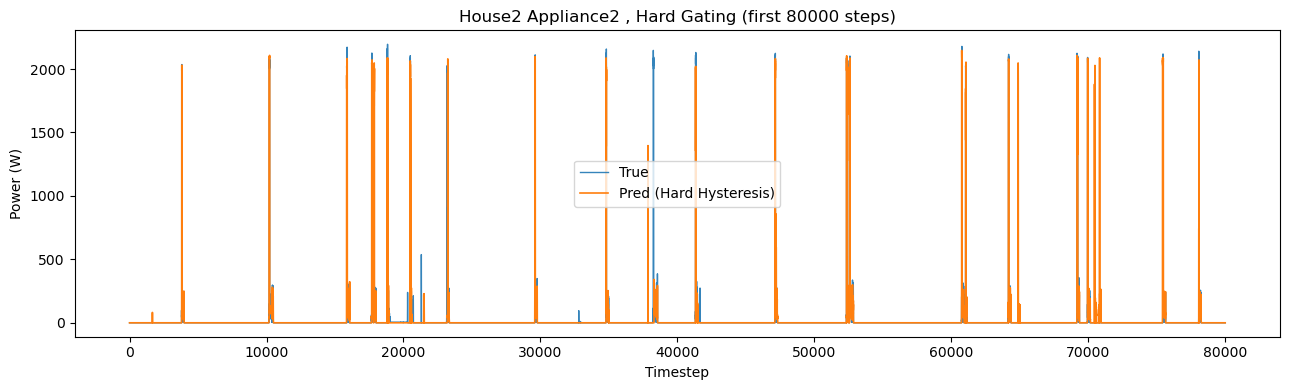

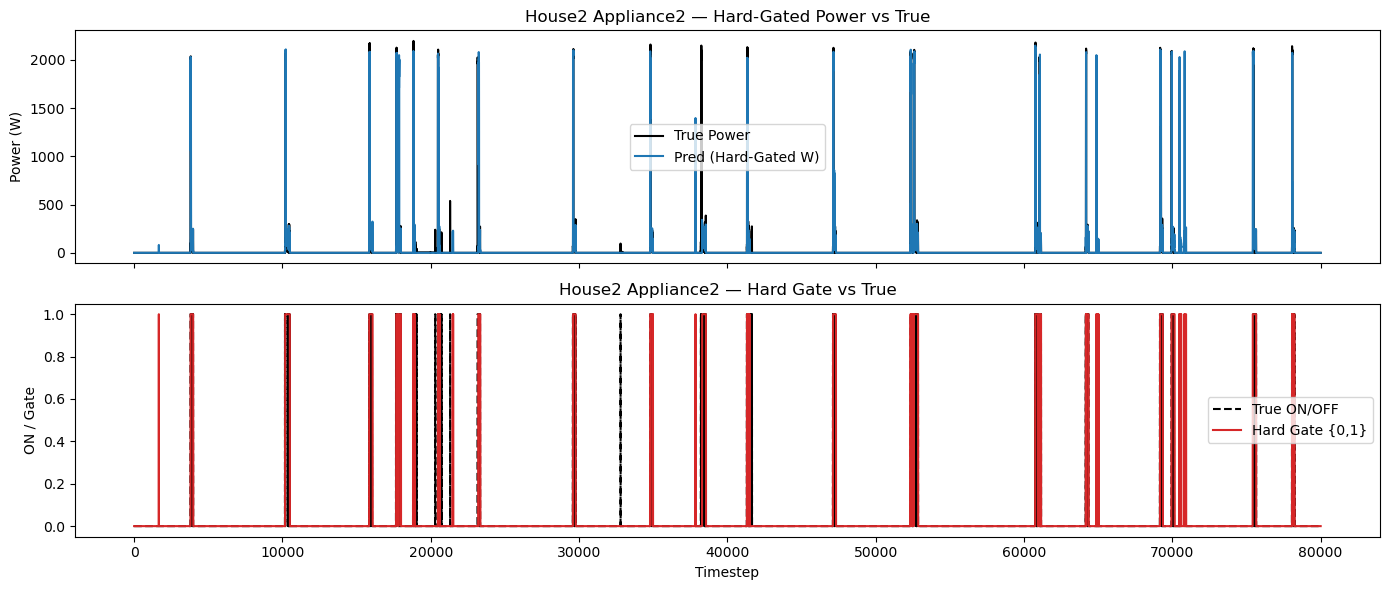

In [ ]:

def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

N = min(80000, len(y_true))

plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(power_soft_w[:N], label="Pred (Gated Power, Soft)")
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} — test slice (soft gating)")
plt.xlabel("Timestep"); plt.ylabel("Power (W)")
plt.tight_layout(); plt.show()

on_threshold = 15.0
true_cls = (y_true[:N] > on_threshold).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax1.plot(y_true[:N], label="True Power", color="black")
ax1.plot(reg_w[:N], label="Regression Output (W)", color="tab:blue")
ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Regression vs True")
ax1.legend()

ax2.plot(true_cls, label="True ON/OFF", color="black", linestyle="--")
ax2.plot(prob[:N], label="Predicted ON Probability", color="tab:red")
ax2.set_ylabel("ON Probability")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Classification vs True")
ax2.legend()



plt.tight_layout(); plt.show()
plt.figure(figsize=(13,4))
plt.plot(y_true[:N], label="True", linewidth=1.0, alpha=0.9)
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} , Hard Gating (first {N} steps)")
plt.xlabel("Timestep"); plt.ylabel("Power (W)")
plt.tight_layout(); plt.show()



plt.tight_layout(); plt.show()
plt.figure(figsize=(13,4))
plt.plot(y_true[:N], label="True", linewidth=1.0, alpha=0.9)
plt.plot(power_hard_w[:N], label="Pred (Hard Hysteresis)", linewidth=1.2)
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} , Hard Gating (first {N} steps)")
plt.xlabel("Timestep"); plt.ylabel("Power (W)")
plt.tight_layout(); plt.show()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# --- Top: True vs Hard-gated power ---
ax1.plot(y_true[:N],            label="True Power",            color="black")
ax1.plot(power_hard_w[:N],      label="Pred (Hard-Gated W)",   color="tab:blue")

ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Hard-Gated Power vs True")
ax1.legend()


ax2.plot(true_cls[:N],          label="True ON/OFF",           color="black", linestyle="--")
ax2.plot(gate_hard[:N],         label="Hard Gate {0,1}",       color="tab:red")
ax2.set_ylabel("ON / Gate")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Hard Gate vs True")
ax2.legend()

plt.tight_layout(); plt.show()
